In [1514]:
# import useful packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
import pickle
import statistics
import math
%matplotlib inline
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [1515]:
# Function to extract and return image points and object points for images in camera_cal folder
def extract_points():
    # Read in and make alist of all the calibration images
    name = glob.glob('camera_cal/calibration*.jpg')

    # prepare object points
    nx = 9 # number of inside corners in x
    ny = 6 #number of inside corners in y

    objpoints = [] # 3D points in the real world
    imgpoints = [] # 2D points in the image plance

    # Prepare object points like (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (nx-1, ny-1, 0)
    objp = np.zeros((nx * ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # iterate through each image in camera_cal folder
    for image in name:
        # read in each image
        img = mpimg.imread(image)
        size = (img.shape[1], img.shape[0])
        
        # convert to grayscale image
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        
        # find chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # draw and display the corners
            #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret) ## uncomment to draw and display the image
            #plt.imshow(img)
            #plt.show()
        else:
            img_name = image.split('/')[1] 
            print('Could not detect the corners in '+ str(img_name))
    return imgpoints, objpoints, size

# A function that find an store calibration matrix (mtx) and distortion coefficients (dist) in a pickle db file
def cal_mtx_dist():
    
    ## extract and store the imgpoint and objpoints in a pickle db file
    imgpoints, objpoints, size = extract_points()    
    
    # Use cv2.calibrateCamera() 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, size, None, None)
    return mtx, dist
# Call to calculate and store camera calibration matrix and coefficients in a pickle db file...
mtx, dist = cal_mtx_dist()

Could not detect the corners in calibration4.jpg
Could not detect the corners in calibration1.jpg
Could not detect the corners in calibration5.jpg


In [1516]:
# Function to compute absolute the gradient in x or y direction of S channel image
def abs_sobel_thresh(img, orient ='x', sobel_kernel=3, thresh=(0, 255)):
    
    gray = np.copy(img)
    # Calculate directional gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Calculate absolute sobel
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_abs_sobel = np.uint8(255 * (abs_sobel/np.max(abs_sobel)))
   
    # Create a mask of 1's where the scaled gradient magnitude is > (or >=) thresh_min and <  (or <= ) thresh_max
    scaled_abs_sobel_b = np.zeros_like(scaled_abs_sobel)
    scaled_abs_sobel_b[(scaled_abs_sobel >= thresh[0]) & (scaled_abs_sobel <= thresh[1])] = 1
    
    #Return this mask as your binary_output image
    return scaled_abs_sobel_b

# Function to calcualte the magnitude of the gradientof S channel image 
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    gray = np.copy(img)
    # Calculate gradient in x and y directions
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Calcualte the magnitude of gradient 
    sobel_mag = cv2.sqrt((sobel_x * sobel_x) + (sobel_y * sobel_y))
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel_mag = np.uint8(255 * (sobel_mag / np.max(sobel_mag)))
    
    # Create a mask of 1's where the scaled gradient magnitude is > (or >=) thresh_min and <  (or <= ) thresh_max
    scaled_sobel_mag_b = np.zeros_like(scaled_sobel_mag)
    scaled_sobel_mag_b[(scaled_sobel_mag >= mag_thresh[0]) & (scaled_sobel_mag <= mag_thresh[1])] = 1
    
    # Return this mask as your binary_output image
    return scaled_sobel_mag_b

# Function to calcualte the direction of the gradient of S channel image
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
   
    gray = np.copy(img)
    # Calculate gradient in both x and y direction
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # Calculate absolute gradient 
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    sobel_dir = np.arctan2(abs_sobel_y,abs_sobel_x)
  
    # Apply threshold
    sobel_dir_b = np.zeros_like(sobel_dir)
    sobel_dir_b[(sobel_dir > thresh[0]) & (sobel_dir < thresh[1])] = 1
    
     # Return this mask as your binary_output image
    return sobel_dir_b

#  Function to select source and destination points for perceptive transform 
def select_src_dst(img):
    # select 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[260, img.shape[0]-50], [570, 460], [720, 460], [1080, img.shape[0]-50]])
    # select4 destination points dst = np.float32([[,],[,],[,],[,]])
    offset = 240
    h = img.shape[0]
    w = img.shape[1]
    img_size = (w, h)
    dst = np.float32([[offset,h],[offset,0],[w-offset,0],[w-offset,h]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return M, Minv, warped


In [1517]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        #print('Top Left: (', win_xleft_low,win_y_low, ') Bottom Right: (', win_xleft_high,win_y_high,')')
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if good_left_inds.shape[0] > minpix:
            leftx_current = np.int(statistics.mean(nonzerox[good_left_inds]))
        if good_right_inds.shape[0] > minpix:
            rightx_current = np.int(statistics.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
    # Extract left and right line pixel positions 
    # int_() or int32() are same 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    #out_img[lefty, leftx] = [255, 0, 0]
    #out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='red')
    #plt.plot(right_fitx, ploty, color='red')

    return left_fit, right_fit, left_fitx, right_fitx, out_img


In [1518]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty  + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):

    # Choose the width of the margin around the previous polynomial to search
    margin = 100
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### within the +/- margin of our polynomial function ###
    left_lane_inds = (nonzerox > (left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0] * nonzeroy**2 + left_fit[1] * nonzeroy + 
    left_fit[2] + margin))
    right_lane_inds = (nonzerox > (right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0] * nonzeroy**2 + right_fit[1] * nonzeroy + 
    right_fit[2] + margin))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
   
    """
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    """
    return left_fit, right_fit, left_fitx, right_fitx

In [1519]:
def plot_unwarp(left_fitx, right_fitx, Minv, warped, image):
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result
    #plt.imshow(result)
    #plt.show()

In [1520]:
def combined_binary_img(warped, orient = 'x', sobel_kernel = 3, sobel_kernel_d = 9, thresh = (25, 255), thresh_s = (10, 255), 
                thresh_m = (10,255), thresh_d = (0, 1.57)):
     # convert warped image to gray scale
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)  
    # find binary gradient image of gray image in x direction
    gray_b = abs_sobel_thresh(gray, orient, sobel_kernel, thresh)
    # find binary gradient image of S channels in x direction
    hls_img = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    S = hls_img[:,:,2]
    sobel_bs = abs_sobel_thresh(S, orient, sobel_kernel, thresh_s)
    
    # magnitude and direction of gradient of S channel 
    s_img = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2]
    mag_binary = mag_thresh(s_img, sobel_kernel, thresh_m)
    dir_binary = dir_threshold(s_img, sobel_kernel_d, thresh_d)
        
    # Combine grad_x, mag_binary, and dir_binary
    combined = np.zeros_like(mag_binary)
    combined[((gray_b == 1) | (sobel_bs == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

In [1564]:
def measure_curvature_real(combined, left_fitx, right_fitx):
    # Generate y values for plotting
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0])    
    
    # fit left and right polynomial
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty) 
    y_eval = y_eval * ym_per_pix
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + ((2 * left_fit_cr[0] * y_eval) + left_fit_cr[1])**2)**(3/2))/abs(2 * left_fit_cr[0])
    right_curverad = ((1 + ((2 * right_fit_cr[0] * y_eval) + right_fit_cr[1])**2)**(3/2))/abs(2 * right_fit_cr[0])
    
    curv_radius = (left_curverad + right_curverad) / 2
    
    return left_curverad, right_curverad, curv_radius


def location_of_car(combined, left_fit, right_fit):
    # actual lane center 
    lane_center = combined.shape[1] // 2

    # maximum y pixel of region of interest
    max_y = combined.shape[0] - 50
    
    # calculte left and right bottom x
    left_bottom_x = left_fit[0] * max_y**2 + left_fit[1] * max_y + left_fit[2]
    right_bottom_x = right_fit[0] * max_y**2 + right_fit[1] * max_y + right_fit[2]
    
    # mid x pixel of the lane lines
    lane_mid_x = (left_bottom_x + right_bottom_x) // 2
    
    car_loc = (lane_center - lane_mid_x) * xm_per_pix
    
    return car_loc

def draw_on_image(curv_radius, car_loc, unwarp_img):
  
    font = cv2.FONT_HERSHEY_SIMPLEX
    text1 = 'Radius of Curvature = ' + str(round(curv_radius/1000,2)) + 'km'
    # Using cv2.putText() method
    unwarp_img = cv2.putText(unwarp_img, text1, (50, 100), font, 
                   1.5, (255, 80, 60), 2, cv2.LINE_AA)
    if car_loc < 0:
        text2 = 'Vehicle is ' + str(round(abs(car_loc),2)) + 'm left to the center'
    else:
        text2 = 'Vehicle is ' + str(round(abs(car_loc),2)) + 'm right to the center'
    # Using cv2.putText() method
    unwarp_img = cv2.putText(unwarp_img, text2, (50, 200), font, 
                    1.5, (255, 80, 60), 2, cv2.LINE_AA)
    
    return unwarp_img

In [1565]:
def sanity_check(left_fit, right_fit, left_fitx, right_fitx):
    dd = (right_fitx - left_fitx) * xm_per_pix
    dd_avg = np.average(np.array(dd), axis=0)
    print(dd_avg)
    diffs = abs(left_fit - right_fit)
    print(diffs)

In [1566]:
## function to undistort, and apply combined thresholding (i.e., sobel gradeient thresholding plus color thresholding)
# on the sample images and save them in output_images folder
def pipeline_image(input):    
    # Read in and make alist of all the calibration images
    name = glob.glob(input)
    for image in name:   
        # read in the image
        img = mpimg.imread(image)
        original_img = np.copy(img)
        
        #undistort each image
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        #plot_line(undist)
        M, Minv, warped = select_src_dst(undist)
        
        # Gradient and Color Thresholding
        combined = combined_binary_img(warped)
        # Finding left and right lanes
        left_fit, right_fit, left_fitx, right_fitx, out_img = fit_polynomial(combined)  

        sanity_check(left_fit, right_fit, left_fitx, right_fitx)
        #measure curvature
        left_curverad, right_curverad, curv_radius = measure_curvature_real(combined, left_fitx, right_fitx)
        #print(left_curverad, right_curverad,curv_radius)
        #location of car
        car_loc = location_of_car(combined, left_fit, right_fit)
        
        # unwarp the image
        unwarp_img = plot_unwarp(left_fitx, right_fitx, Minv, combined, original_img)
        
        # draw on image
        unwarp_img = draw_on_image(curv_radius, car_loc, unwarp_img)
        plt.imshow(unwarp_img)
        plt.show()


3.67108184643
[  1.65196978e-05   9.27129409e-02   6.64047355e+02]


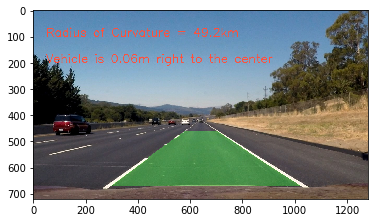

3.59789210727
[  8.92854771e-05   5.27658273e-02   6.46316573e+02]


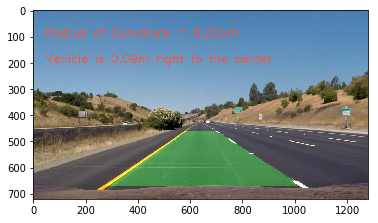

In [1567]:
# Software pipeline for creating and storing combined binary thresholded image,
# i.e., gradient thresholding + color threshodling
input = 'test_images/straight_lines*.jpg'
pipeline_image(input)

3.79101705578
[  1.12140179e-04   1.62038719e-01   6.78303995e+02]


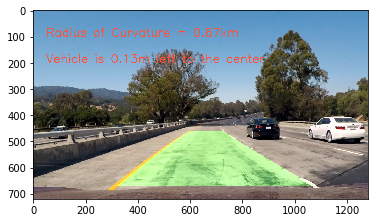

3.59862442175
[  9.16236106e-05   6.86772851e-02   6.40331762e+02]


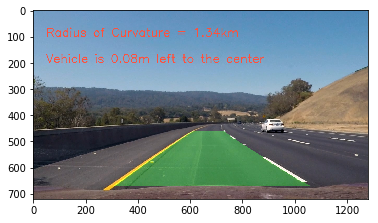

3.7859222619
[  1.15914456e-04   3.33849531e-02   7.08269146e+02]


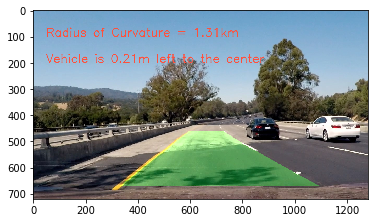

4.02852248819
[  2.35790742e-04   2.63005462e-01   7.08262234e+02]


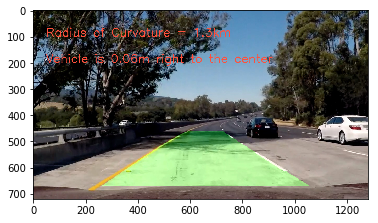

3.66228533739
[  4.41800338e-06   1.68068694e-01   6.31682257e+02]


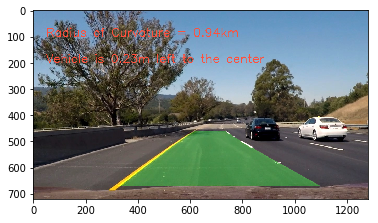

3.59056149074
[  1.24443825e-04   1.70059104e-01   6.39618283e+02]


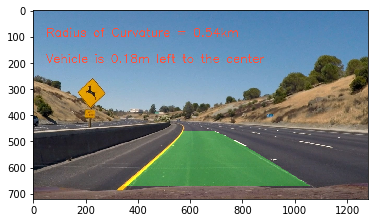

In [1568]:
# undistort sample road images with curving lane lines in test_images folder
input = 'test_images/test*.jpg'
pipeline_image(input) 

In [1569]:
def pipeline_video(img):  
    original_img = np.copy(img)
    
    #undistort each image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # warp the undistorted iamge
    M, Minv, warped = select_src_dst(undist)
    
    # combined Gradient and Color Thresholding
    combined = combined_binary_img(warped)
           
    # Finding left and right lanes
    left_fit, right_fit, left_fitx, right_fitx, out_img = fit_polynomial(combined)
    
    #measure curvature
    left_curverad, right_curverad, curv_radius = measure_curvature_real(combined,left_fitx, right_fitx)
        
    #location of car
    car_loc = location_of_car(combined, left_fit, right_fit)
    
    # unwarp the image
    unwarp_img = plot_unwarp(left_fitx, right_fitx, Minv, combined, original_img)
    
    # draw on image
    unwarp_img = draw_on_image(curv_radius, car_loc, unwarp_img)
    
    return unwarp_img

In [1570]:
def find_bestfitx(combined, left_line, right_line):
    # find x and y pixel indices of best fit lane lines
    ploty = np.linspace(0, combined.shape[0]-1, combined.shape[0] )
    left_bestfitx = left_line[0] * ploty**2 + left_line[1] * ploty  + left_line[2]
    right_bestfitx = right_line[0] * ploty**2 + right_line[1] * ploty +  right_line[2]
    
    return left_bestfitx, right_bestfitx 

In [1571]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        #self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        #self.diffs = np.array([0,0,0], dtype='float') 
        #self.dist = []
        #x values for detected line pixels
        #self.allx = None  
        #y values for detected line pixels
        #self.ally = None  

In [1572]:
def sanity_check(left_fit, right_fit, left_fitx, right_fitx):
    # calculate distance between left line and right line for each pixel
    dd = (right_fitx - left_fitx) * xm_per_pix
    
    # calcuate the average distance
    dd_avg = np.average(np.array(dd), axis=0)
    
    # flag for distance and parallelism
    d_bool = False
    
    # flag for curvature
    c_bool = False
    # check if lane lines are within acceptable distance
    if dd_avg >= 3.4 and dd_avg <= 4.0:
        d_bool = True # set the flag
    
    # calculate the difference between left and right lanes curvature
    diffs = abs(left_fit - right_fit)
    
    # check if curvature is within acceptable range
    if diffs[0] <= 0.001:
        c_bool = True # set flag
        
    # check if distance, parallelism and curvature are acceptable 
    bool = d_bool and c_bool
    
    return bool

In [1573]:
# function for calculating exponential weighted moving average over a sing attribute
def EMWA(alpha, coeff, n):
    if n == 0:
        return coeff[n]
    else:
        x1 = alpha * coeff[n]
        n = n - 1
        x2 = (1 - alpha) * EMWA(alpha, coeff, n)
        x = x1 + x2
        return x
    
# function for caluateing eponential weighted moving average over polynomial
def a_line(coeff):
    coeff = coeff.T
    avg_coeff = []
    alpha = 0.7
    for c in coeff:
        n = len(c) -1
        avg = EMWA(alpha, c, n)
        avg_coeff.append(avg)
    return np.array(avg_coeff)

In [1574]:
def print_and_unwarp(v_bool, combined, original_img, Minv, left_fit, right_fit, left_fitx, right_fitx):
    
    n = 15
    # save left fit and right fit in current_fit of Line if its from sliding window or good search around polynomial
    if v_bool == True:
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
        
        # if list has more than n recent fits then pop from the left
        if len(left_line.recent_xfitted) > n and len(right_line.recent_xfitted) > n:
            left_line.recent_xfitted.pop(0)
            right_line.recent_xfitted.pop(0
                                     )
        # append new good fits to left and right lines
        left_line.recent_xfitted.append(left_fit)
        right_line.recent_xfitted.append(right_fit)
    
        # update best fit using exponential weighted moving average over last n good frames
        left_line.best_fit = a_line(np.array(left_line.recent_xfitted))
        right_line.best_fit = a_line(np.array(right_line.recent_xfitted))
    
    # update best fit using simple average over last n good frames
    #left_line.best_fit = np.average(np.array(left_line.recent_xfitted), axis=0)
    #right_line.best_fit = np.average(np.array(right_line.recent_xfitted), axis=0)
    
    # find curvature of the road
    left_curverad, right_curverad, curv_radius = measure_curvature_real(combined, left_fitx, right_fitx)
    
    # find location of the car
    car_loc = location_of_car(combined, left_fit, right_fit)
    
    # unwarp the image
    unwarp_img = plot_unwarp(left_fitx, right_fitx, Minv, combined, original_img)
            
    # draw on image
    unwarp_img = draw_on_image(curv_radius, car_loc, unwarp_img)  
    
    return unwarp_img

In [1575]:
def pipeline_video(img):  
    original_img = np.copy(img)

    #undistort each image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # warp the undistorted iamge
    M, Minv, warped = select_src_dst(undist)
    
    v_bool = True
    # combined Gradient and Color Thresholding
    combined = combined_binary_img(warped)
    
    if left_line.detected == False and right_line.detected == False:
        # finding left and right lanes using sliding window method
        left_fit, right_fit, left_fitx, right_fitx, out_img = fit_polynomial(combined)
        
        # enable Searching Around Method
        left_line.detected = True
        right_line.detected = True
    else:
        # findomg left and right lanes using search around method
        left_fit, right_fit, left_fitx, right_fitx = search_around_poly(combined, left_line.best_fit, 
                                                                                 right_line.best_fit)
        # perform sanity check
        v_bool = sanity_check(left_fit, right_fit, left_fitx, right_fitx)
        
        # if sanity check fails reset to sliding window method
        if v_bool == False:     
            left_line.detected = False
            right_line.detected = False
            
    # update content of Line() object and print and unwarp the image
    unwarp_img = print_and_unwarp(v_bool, combined, original_img, Minv, left_fit, right_fit, left_fitx, right_fitx)    
    return unwarp_img

In [1576]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [1577]:
def process_image(image):
    annoted_image = pipeline_video(image)
    return annoted_image

In [1578]:
left_line = Line()
right_line = Line()
#print(left_line.detected)

In [1579]:
video_output = "project_video_output2.mp4"
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #.subclip(38,43)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output2.mp4
[MoviePy] Writing video project_video_output2.mp4


100%|█████████▉| 1260/1261 [06:03<00:00,  3.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output2.mp4 

CPU times: user 3min 49s, sys: 3.19 s, total: 3min 52s
Wall time: 6min 6s


In [1580]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))